# Enhancement

## 1. Retrieve Data from MongoDB
Retreive all documents from MongoDB and convrt it to a `pandas.DataFrame`

In [1]:
import pymongo
client = pymongo.MongoClient()

In [2]:
import pandas as pds

db = client.get_database("covid-us")
collection = db.get_collection("covid-us-state")
data = list(collection.find())
df = pds.DataFrame.from_records(data)    
df.drop('_id', axis=1, inplace=True)
df.info

<bound method DataFrame.info of             date          state  fips   cases  deaths
0     2020-01-21     Washington    53       1       0
1     2020-01-22     Washington    53       1       0
2     2020-01-23     Washington    53       1       0
3     2020-01-24     Washington    53       1       0
4     2020-01-25     Washington    53       1       0
...          ...            ...   ...     ...     ...
15189 2020-12-03       Virginia    51  244503    4147
15190 2020-12-03     Washington    53  180125    3040
15191 2020-12-03  West Virginia    54   51025     789
15192 2020-12-03      Wisconsin    55  426534    3781
15193 2020-12-03        Wyoming    56   35078     257

[15194 rows x 5 columns]>

## 2. Trend and Prediction

Now let's make a what-if analysis.

In [3]:
# import plotly.figure_factory as ff

# import numpy as np
# import pandas as pd

# df_sample = pd.read_csv(
#     'https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv'
# )
# df_sample_r = df_sample[df_sample['STNAME'] == 'Rhode Island']

# values = df_sample_r['TOT_POP'].tolist()
# fips = df_sample_r['FIPS'].tolist()

# binning_endpoints = list(np.mgrid[min(values):max(values):4j])
# colorscale = ["#030512","#1d1d3b","#323268","#3d4b94","#3e6ab0",
#             "#4989bc","#60a7c7","#85c5d3","#b7e0e4","#eafcfd"]
# fig = ff.create_choropleth(
#     fips=fips, values=values, scope=['Rhode Island'], show_state_data=True,
#     colorscale=colorscale, binning_endpoints=binning_endpoints,
#     round_legend_values=True, plot_bgcolor='rgb(229,229,229)',
#     paper_bgcolor='rgb(229,229,229)', legend_title='Florida Population',
#     county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
#     exponent_format=True,
# )

In [4]:
# Build AppViewer 
from jupyterlab_dash import AppViewer
viewer = AppViewer()

In [84]:
from utils import get_state_codes, get_state_name, daily_increase, moving_average
from utils import all_states, state_code_dict, state_map_dict

In [97]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import numpy as np
import plotly.graph_objects as go

from database import fetch_all_db_as_df

# Definitions of constants. This projects uses extra CSS stylesheet at `./assets/style.css`
COLORS = ['rgb(67,67,67)', 'rgb(115,115,115)', 'rgb(49,130,189)', 'rgb(189,189,189)']
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css', '/assets/style.css']
colors = { 
"cases": 'rgba(80, 26, 80, 0.2)', 
"deaths": 'rgba(16, 112, 2, 0.2)'
}
colors_bar = { 
"cases": 'mediumturquoise', 
"deaths": 'tomato'
}
colors_line = {
    "cases": "mediumturquoise",
    "deaths": "tomato"
}
colors_text = {
    "cases": "purple",
    "deaths": "olivedrab"   
}

# Define the dash app first
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

df_dict = fetch_all_db_as_df()

# Define component functions

def page_header():
    """
    Returns the page header as a dash `html.Div`
    """
    return html.Div(id='header', children=[
        html.Div([html.H3('DATA1050 Final Project')],
                 className="ten columns"),
        html.A([html.Img(id='logo', src=app.get_asset_url('github.png'),
                         style={'height': '35px', 'paddingTop': '7%'}),
                html.Span('Old boys', style={'fontSize': '2rem', 'height': '35px', 'bottom': 0,
                                                'paddingLeft': '4px', 'color': '#a3a7b0',
                                                'textDecoration': 'none'})],
               className="two columns row",
               href='https://github.com/cengc13/data1050-final-project'),
    ], className="row")


def project_description():
    """
    Returns overall project description in markdown
    """
    return html.Div(children=[dcc.Markdown('''
        # US COVID-19 Tracker
        
        The coronavirus pandemic has caused more than one and half million deaths over the world. 
        The COVID-19 has exhausted the United States, and it seems a dark and deadly winter is waiting ahead. 
        Therefore, it is of crucial importance to understand and project the trend of COVID-19 cases in US 
        so that policy-makers can come up with short-term and long-term strategies to limit the spread and
        mitigate the effect of another outbreak in the near future.

        **US COVID-19 tracker is also a "What-If" tool to assist making strategies.**
        It can be used to understand and project the trend if more precautions and restrictions are imposed.

        ## Data Source
        Covid-19 tracker mainly utilizes historical and live covid-19 data from 
        [New York Times github repository](https://github.com/nytimes/covid-19-data).
        The hirarchical case and death [data](https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv) 
        **is regularly updated every day**.
        
        Also, the data for state and county population is merged to obtain the positive rate over population at different 
        geographical levels.
        
        Additionally, the [survey data](https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv) 
        by New York time on maks use by county is investigated to see if there exists a 
        correlation between the outbreak and mask use frequency in each state. All data sets in this project are well-structured.
        ''', className='eleven columns', style={'paddingLeft': '5%'})], className="row")


def visualization_description():
    """
    Returns the text and plots of EDA and interactive visualization of this project.
    """
    return html.Div(children=[
      dcc.Markdown('''
            ## EDA & Interactive Visualization
            This project uses `Dash` and `Plotly` for visualization. We use the 
            high-level components/tools in Dash to provide compact figures which allow user
            to choose what to display. For example, we utilized radio items to select targets 
            (case or death number), dropdown layout to select the state, and slider to select
            time points.
            
            Curve plots are used to show the time variation of cumulative and daily reported 
            cases and deaths for the  national-level and state-level covid-19 data. Heat maps are used
            to track the outbreak geographically. Bar/pie plots are mainly for comparison. 
            
        ''', className='row eleven columns', style={'paddingLeft': '5%'}),      
    ]
    )

def heat_map_description():
    """
    Returns description of "What-If" - the interactive component
    """
    return html.Div(children=[
        dcc.Markdown('''
        ### " Heat Map "
        We use the state-level COVID-19 data to power the heat map and track the outbreak
        over all states of US. 
        ''', className='eleven columns', style={'paddingLeft': '5%'})
    ], className="row")

# Defines the dependencies of interactive components
@app.callback(Output('time-series-total', 'figure'),
             Input('target-label', 'value'))
def time_series_cumulative(label):
    df = df_dict['covid-us']
    x = df['date']
    trace = go.Scatter(x=x, y=df[label], mode='lines', name=label, fill='tozeroy',
                       fillcolor=colors[label], 
                       line={'width': 2, 'color': colors[label]},
                       hovertemplate='%{x|%b %d, %Y} <br> %{y:-.0f}' 
                      )

    title = f'Cumulative Covid {label.lower()} in U.S. over time'
    layout = dict(title=title,
                  yaxis_title=f'# of {label}',
                  xaxis_title='Date/Time',
                  font=dict(family="Courier New, monospace",
                            size=16))
    data = [trace]
    fig = dict(data=data, layout=layout)
    return fig

@app.callback(Output('time-series-daily', 'figure'),
             Input('daily-label', 'value'))
def time_series_daily(label, window_size=7):
    df = df_dict['covid-us']
    x = df['date']
    daily = daily_increase(df[label])
    moving_avg = moving_average(daily, window_size)
    
    trace1 = go.Bar(x=x, y=daily, name=f'Daily new {label}',
                    marker = dict(color = colors_bar[label],
                                  line=dict(color=colors_bar[label],width=1.5),
                                  opacity=0.2),
                    hovertemplate='%{x|%b %d, %Y} <br>Daily: %{y:-.0f}' 
                   )
    trace2 = go.Scatter(x=x, y=moving_avg, 
                        name=f'Moving average in {window_size} days',
                        line={'width':3, 'color': colors_line[label]},
                        hovertemplate='Moving average: %{y:-.0f}' 
                        )
    
    title = f'Daily reported new Covid {label.lower()} in U.S. over time'
    layout = dict(title=title,
                  yaxis_title=f'# of {label} per day',
                  xaxis_title='Date/Time',
                  font=dict(family="Courier New, monospace",
                            size=16),
                  hoverlabel=dict(
                            bgcolor="white",
                            font_size=16,
                            font_family="Rockwell"),
                  hovermode='x Unified',
                  legend=dict(
                        yanchor="top",
                        y=0.99,
                        xanchor="left",
                        x=0.01)
                 )
    data = [trace1, trace2]
    fig = dict(data=data, layout=layout)
    return fig

@app.callback(Output('time-series-state', 'figure'),
            Input('target-for-state',' value'),
            Input('plot-type', 'value'),
            Input('state-name', 'value'))
def time_series_state(label, plot_type, state_name):
    df = df_dict['covid-us-state']
    df['state_code'] = df['state'].apply(lambda x: state_code_dict[x])
    state_code = state_code_dict[state_name]
    df_state = df[df.state_code == state_code]
    state = state_name
    df_state = df_state.sort_values(by='date')
    x = df_state.date
    y = df_state[label].values
    if plot_type == 'daily':
        window_size = 7
        daily_cases = daily_increase(y)
        moving_avg = moving_average(daily_cases, window_size)
        trace_bar = go.Bar(x=x, y=daily_cases, name=f'Daily new {label}',
                    marker = dict(color = colors_bar[label],
                                  line=dict(color=colors_bar[label],width=1.5),
                                  opacity=0.2),
                    hovertemplate='Date: %{x|%A, %b %d, %Y} <br> Daily increase : %{y:.0f}'
                   )
        trace_line = go.Scatter(
            x=x,
            y=moving_avg, 
            name=f'Moving average in {window_size} days',
            line={'width':1.5, 'color': colors_line[label]},
            hovertemplate='7 Day Avg. : %{y:.0f}')
        title = f'Daily reported new Covid {label.lower()} in {state}'
        layout = dict(title=title,
              yaxis_title=f'# of {label} per day',
              xaxis_title='Date/Time',
              font=dict(family="Courier New, monospace",
                        size=16))
        fig = dict(data=[trace_bar, trace_line], layout=layout)
        return fig
    elif plot_type == 'cumulative':
        trace = go.Scatter(x=x, y=y, mode='lines', name=label, fill='tozeroy',
                       fillcolor=colors[label], 
                       line={'width': 2, 'color': colors[label]},
                       hovertemplate='%{x|%b %d, %Y} <br> %{y:-.0f}' 
                      )

        title = f'Cumulative Covid {label.lower()} in {state}'
        layout = dict(title=title,
                      yaxis_title=f'Confirmed # of {label}',
                      xaxis_title='Date/Time',
                      font=dict(family="Courier New, monospace",
                                size=16))
        data = [trace]
        fig = dict(data=data, layout=layout)
        return fig
    
@app.callback(Output('heat-map', 'figure'),
              Input('time-slider', 'value'),
              Input('label-radioitems', 'value'))
def heat_map(month, label):
    """Create the heap map of given label in US at the beginning of given month"""
    df_dict = fetch_all_db_as_df(allow_cached=True)
    df = df_dict['covid-us-state']
    x = df['date']
    df['state_code'] = df['state'].apply(lambda x: get_state_codes(x))

    return fig

def architecture_summary():
    """
    Returns the text and image of architecture summary of the project.
    """
    return html.Div(children=[
        dcc.Markdown('''
            ## Project Architecture
            This project uses MongoDB as the database. All data acquired are stored in raw form to the
            database (with de-duplication). An abstract layer is built in `database.py` so all queries
            can be done via function call. For a more complicated app, the layer will also be
            responsible for schema consistency. A `plot.ly` & `dash` app is serving this web page
            through. Actions on responsive components on the page is redirected to `app.py` which will
            then update certain components on the page.  
        ''', className='row eleven columns', style={'paddingLeft': '5%'}),

        html.Div(children=[
            html.Img(src="https://docs.google.com/drawings/d/e/2PACX-1vQNerIIsLZU2zMdRhIl3ZZkDMIt7jhE_fjZ6ZxhnJ9bKe1emPcjI92lT5L7aZRYVhJgPZ7EURN0AqRh/pub?w=670&amp;h=457",
                     className='row'),
        ], className='row', style={'textAlign': 'center'}),

        dcc.Markdown('''
        
        ''')
    ], className='row')


def visualization_summary():
    """
    All EDA figures should be arranged in this function.
    """
    return html.Div(children=[
        dcc.Markdown('''
        ### US Case and Death Count
        ''', className='row eleven columns', style={'paddingLeft': '5%'}),
        
            # Time series curves for cumulative cases and deaths in US
            dcc.Markdown('''
            #### Time-series cumulative cases and deaths
            ''', className='row eleven columns', style={'paddingLeft': '5%'}),
        
            html.Div([
                html.Div([                    
                    html.Label( ['Label:'],
                        style={'font-weight': 'bold', 'float': 'left', 
                               'color': 'white', 'display': 'inline-block', 
                               },
                        ),
                    dcc.RadioItems(
                        id='target-label',
                        options=[{'label': i.title(), 'value': i} for i in ['cases', 'deaths']],
                        value='cases',
                        labelStyle={
                        'display': 'inline-block',
                        },
                        style={
                        'width': '20%',
                        'float': 'left',
                        'font-weight': 'bold',
                        'color': 'white',
                        }),],  style={'width': '98%', 'display': 'inline-block'}),
                dcc.Graph(id='time-series-total', style={'height': 500, 'width': 1100})
                ],
                style={'width': '98%', 'float': 'right', 'display': 'inline-block'}),

            # Time series curves for daily cases and deaths in US
                    dcc.Markdown('''
            #### Time-series daily reported cases and deaths
            ''', className='row eleven columns', style={'paddingLeft': '5%'}), 
            html.Div([
                html.Div([ 
                    html.Label( ['Label:'],
                        style={'font-weight': 'bold', 'float': 'left', 
                               'color': 'white', 'display': 'inline-block', 
                               },
                        ),
                    dcc.RadioItems(
                        id='daily-label',
                        options=[{'label': i.title(), 'value': i} for i in ['cases', 'deaths']],
                        value='cases',
                        labelStyle={
                        'display': 'inline-block',
                        },
                        style={
                        'width': '20%',
                        'float': 'left',
                        'font-weight': 'bold',
                        'color': 'white',
                        }),],  style={'width': '98%', 'display': 'inline-block'}),
                dcc.Graph(id='time-series-daily', style={'height': 500, 'width': 1100})
            ],
                style={'width': '98%', 'float': 'right', 'display': 'inline-block'}),
        
        dcc.Markdown('''
        ### Case and Death Count by State
        ''', className='row eleven columns', style={'paddingLeft': '0%'}),
        
             # Time series curves for cases and deaths by state
            dcc.Markdown('''
            #### Time-series cases and deaths by state
            ''', className='row eleven columns', style={'paddingLeft': '5%'}), 
        
            html.Div([
                html.Div([
                    html.Label( ['Label:'],
                        style={'font-weight': 'bold', 'float': 'left', 
                               'color': 'white', 'display': 'inline-block', 
                               },
                        ),
                    dcc.RadioItems(
                        id='target-for-state',
                        options=[{'label': i.title(), 'value': i} for i in ['cases', 'deaths']],
                        value='deaths',
                        labelStyle={
                        'display': 'inline-block',
                        },
                        style={
                        'width': '20%',
                        'float': 'left',
                        'font-weight': 'bold',
                        'color': 'white',
                        }),
                    html.Label( ['Plot type:'],
                        style={'font-weight': 'bold', 'float': 'left', 
                               'color': 'white', 'display': 'inline-block', 
                               },
                        ),
                    dcc.RadioItems(
                        id='plot-type',
                        options=[{'label': i.title(), 'value': i} for i in ['cumulative', 'daily']],
                        value='daily',
                        labelStyle={
                        'display': 'inline-block',
                        },
                        style={
                        'width': '20%',
                        'float': 'left',
                        'font-weight': 'bold',
                        'color': 'white',
                        }),
                    html.Label( ['State:'],
                        style={'font-weight': 'bold', 'float': 'left', 
                               'color': 'white', 'display': 'inline-block', 
                               'margin-right': '10px'
                               },
                        ),
                    dcc.Dropdown(
                        id='state-name',
#                         options=[{'label': i, 'value': i} for i in list(all_states)],
                        options=[{'label': i, 'value': i} for i in ['Rhode Island']],
                        value='Rhode Island',
#                         placeholder="Select State",
                        style={'width': '40%', 'float':'left', 'display': 'inline-block'}
                    ),],  style={'width': '98%', 'display': 'inline-block'}),
                dcc.Graph(id='time-series-state', style={'height': 500, 'width': 1100})
                ],
                style={'width': '98%', 'float': 'right', 'display': 'inline-block'}),
    ])

2020-12-05 20:02:21,750 [fetch_all_db]: 318 documents read from the db
2020-12-05 20:02:21,803 [fetch_all_db]: 15194 documents read from the db
2020-12-05 20:02:22,672 [fetch_all_db]: 211704 documents read from the db
2020-12-05 20:02:22,685 [fetch_all_db]: 3142 documents read from the db


In [98]:
# Sequentially add page components to the app's layout
def dynamic_layout():
    return html.Div([
        page_header(),
        html.Hr(),
        project_description(),
        visualization_description(),
        visualization_summary(),
        architecture_summary(),
    ], className='row', id='content')


# set layout to a function which updates upon reloading
app.layout = dynamic_layout

In [99]:
if __name__ == '__main__':
    viewer.show(app)

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/43345/

Dash is running on http://localhost:43345/proxy/

2020-12-05 20:10:12,491 [fetch_all_db]: 318 documents read from the db
2020-12-05 20:10:12,533 [fetch_all_db]: 15194 documents read from the db
2020-12-05 20:10:13,461 [fetch_all_db]: 211704 documents read from the db
2020-12-05 20:10:13,472 [fetch_all_db]: 3142 documents read from the db


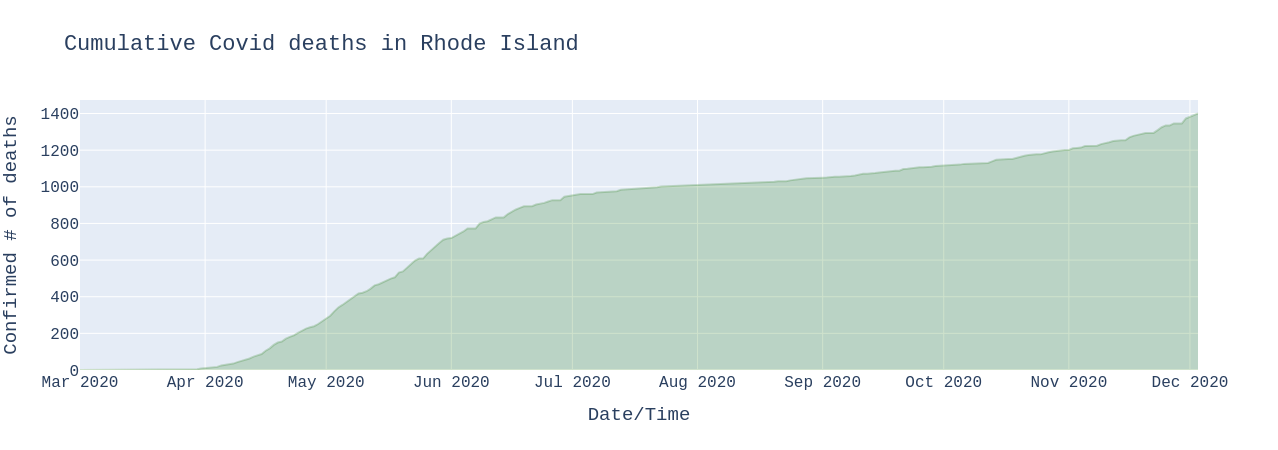

In [101]:
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
def time_series_state(label, plot_type, state):
    df_dict = fetch_all_db_as_df()
    df = df_dict['covid-us-state']
    df_state = df[df.state == state]
    df_state = df_state.sort_values(by='date')
    x = df_state.date
    y = df_state[label].values
    if plot_type == 'daily':
        window_size = 7
        daily_cases = daily_increase(y)
        moving_avg = moving_average(daily_cases, window_size)
        trace_bar = go.Bar(x=x, y=daily_cases, name=f'Daily new {label}',
                    marker = dict(color = colors_bar[label],
                                  line=dict(color=colors_bar[label],width=1.5),
                                  opacity=0.2),
                    hovertemplate='Date: %{x|%A, %b %d, %Y} <br> Daily increase : %{y:.0f}'
                   )
        trace_line = go.Scatter(
            x=x,
            y=moving_avg, 
            name=f'Moving average in {window_size} days',
            line={'width':1.5, 'color': colors_line[label]},
            hovertemplate='7 Day Avg. : %{y:.0f}')
        title = f'Daily reported new Covid {label.lower()} in {state}'
        layout = dict(title=title,
              yaxis_title=f'# of {label} per day',
              xaxis_title='Date/Time',
              font=dict(family="Courier New, monospace",
                        size=16))
        fig = dict(data=[trace_bar, trace_line], layout=layout)
    elif plot_type == 'cumulative':
        trace = go.Scatter(x=x, y=y, mode='lines', name=label, fill='tozeroy',
                       fillcolor=colors[label], 
                       line={'width': 2, 'color': colors[label]},
                       hovertemplate='%{x|%b %d, %Y} <br> %{y:-.0f}' 
                      )

        title = f'Cumulative Covid {label.lower()} in {state}'
        layout = dict(title=title,
                      yaxis_title=f'Confirmed # of {label}',
                      xaxis_title='Date/Time',
                      font=dict(family="Courier New, monospace",
                                size=16))
        data = [trace]
        fig = dict(data=data, layout=layout)
    return fig
fig = time_series_state('deaths', 'cumulative', 'Rhode Island')
iplot(fig)

In [ ]:
# help(dcc.RadioItems)

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

import pandas as pd

viewer = AppViewer()

df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/gapminderDataFiveYear.csv')

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    dcc.Graph(id='graph-with-slider'),
    dcc.Slider(
        id='year-slider',
        min=df['year'].min(),
        max=df['year'].max(),
        value=df['year'].min(),
        marks={str(year): str(year) for year in df['year'].unique()},
        step=None
    )
])


@app.callback(
    Output('graph-with-slider', 'figure'),
    Input('year-slider', 'value'))
def update_figure(selected_year):
    filtered_df = df[df.year == selected_year]

    fig = px.scatter(filtered_df, x="gdpPercap", y="lifeExp",
                     size="pop", color="continent", hover_name="country",
                     log_x=True, size_max=55)

    fig.update_layout(transition_duration=500)

    return fig
